In [47]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import math
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv
/kaggle/input/home-data-for-ml-course/train.csv


In [48]:
test = pd.read_csv("../input/home-data-for-ml-course/test.csv")
train = pd.read_csv("../input/home-data-for-ml-course/train.csv")

In [49]:
new_test  = test.copy()
new_train  = train.copy()

# Exploratory Data Analysis

In [50]:
new_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [51]:
new_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


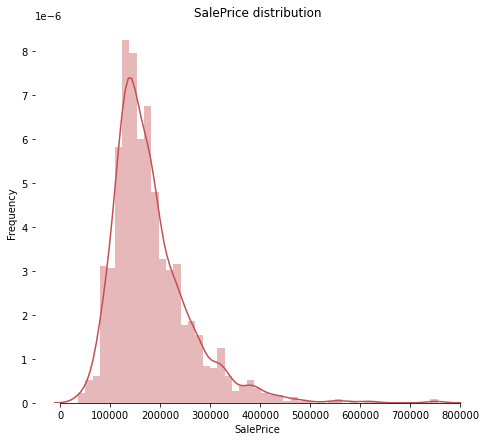

In [52]:
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(new_train['SalePrice'], color="r");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

Correlation of each feature with our target variable

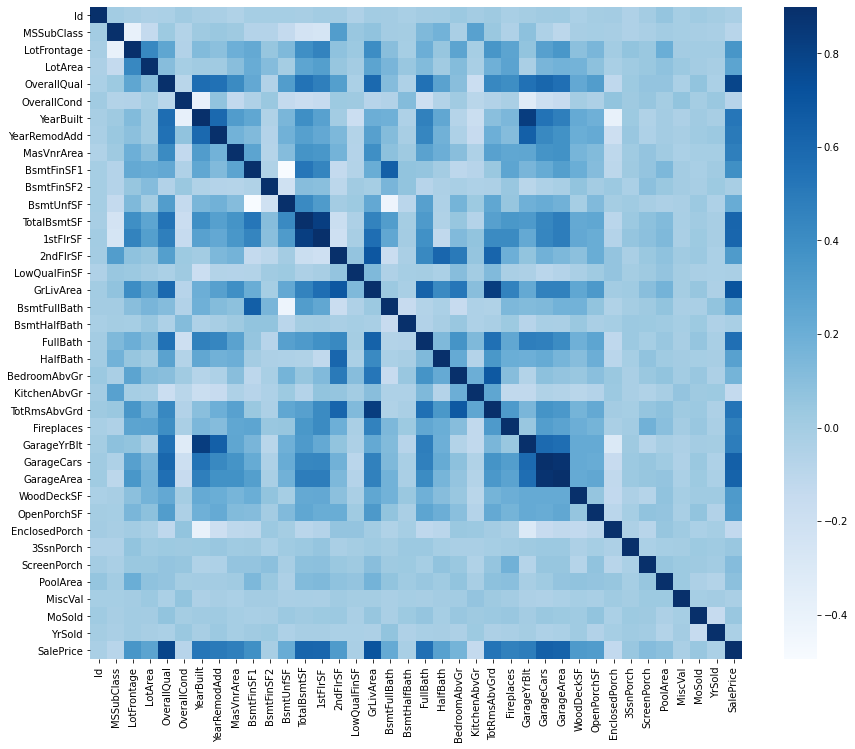

In [53]:
corr = new_train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

**Lets' concat Train and Test datasets**

In [54]:
new_train['train']  = 1
new_test['train']  = 0
new_data=pd.concat([new_train, new_test], axis=0,sort=False)

# Handling Missing Values

In [55]:
def percentage_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percentage_missing(new_data)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percentage of missing data')
df_miss[0:10]

Percentage of missing data


[('PoolQC', 99.66),
 ('MiscFeature', 96.4),
 ('Alley', 93.22),
 ('Fence', 80.44),
 ('SalePrice', 49.98),
 ('FireplaceQu', 48.65),
 ('LotFrontage', 16.65),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45)]

From the above table we can see that PoolQC, MiscFeature, Alley and Fence features have more than 80% of missing values so we can drop them.

In [56]:
new_data = new_data.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)

Seperate numerical and categorical features

In [57]:
object_columns=new_data.select_dtypes(include=['object'])
numerical_columns=new_data.select_dtypes(exclude=['object'])

In [58]:
#Categorical Features
object_columns.dtypes

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

In [59]:
#Numerical columns
numerical_columns.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice        float64
train              int64
dtype: object

In [60]:
#Null values in each categorical feature
null_values = object_columns.isnull().sum()
print("Null values for each categorical feature:\n{}".format(null_values))

Null values for each categorical feature:
MSZoning            4
Street              0
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         1
Functional          2
FireplaceQu      1420
GarageType        157
GarageFinish      159
GarageQual        159
GarageCond        159
PavedDrive          0
SaleType            1
SaleCondition       0
dtype: int64


In [61]:
columns_None = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','FireplaceQu','GarageCond']
object_columns[columns_None]= object_columns[columns_None].fillna('None')

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [62]:
columns_with_low_null_values = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional','SaleType']

object_columns[columns_with_low_null_values] = object_columns[columns_with_low_null_values].fillna(object_columns.mode().iloc[0])


Lets' have a look to our new cleaned data (categorical)

In [63]:
object_columns.describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,...,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919
unique,5,2,4,4,2,5,3,25,9,8,...,4,7,6,7,4,6,6,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,TA,Typ,None,Attchd,Unf,TA,TA,Y,WD,Normal
freq,2269,2907,1859,2622,2918,2133,2778,443,2511,2889,...,1493,2719,1420,1723,1230,2604,2654,2641,2526,2402


Lets' deal with numeric null values now

In [64]:
#Number of null values in each numeric feature
null_values = numerical_columns.isnull().sum()
print("Null values of each numeric values:\n{}".format(null_values))

Null values of each numeric values:
Id                  0
MSSubClass          0
LotFrontage       486
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea         23
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt       159
GarageCars          1
GarageArea          1
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
train               0
dtype: int64


Lets' fill the missing values

In [65]:
print((numerical_columns['YrSold']-numerical_columns['YearBuilt']).median())
print(numerical_columns["LotFrontage"].median())

35.0
68.0


In [66]:
numerical_columns['GarageYrBlt'] = numerical_columns['GarageYrBlt'].fillna(numerical_columns['YrSold']-35)
numerical_columns['LotFrontage'] = numerical_columns['LotFrontage'].fillna(68)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [67]:
numerical_columns= numerical_columns.fillna(0)

Lets' have a look to our new cleaned data (numeric)

In [68]:
numerical_columns.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,57.137718,69.088386,10168.114080,6.089072,5.564577,1971.312778,1984.264474,101.396026,441.272011,...,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,90491.588215,0.500171
std,842.787043,42.517628,21.317898,7886.996359,1.409947,1.113131,30.291442,20.894344,178.854579,455.606014,...,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,106496.379333,0.500086
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000
25%,730.500000,20.000000,60.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,0.000000,0.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,...,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,34900.000000,1.000000
75%,2189.500000,70.000000,78.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,163.500000,733.000000,...,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,163000.000000,1.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000,1.000000


Lets' plot some columns to find ones with low variance so that we can delete them.

Pave    2907
Grvl      12
Name: Street, dtype: int64

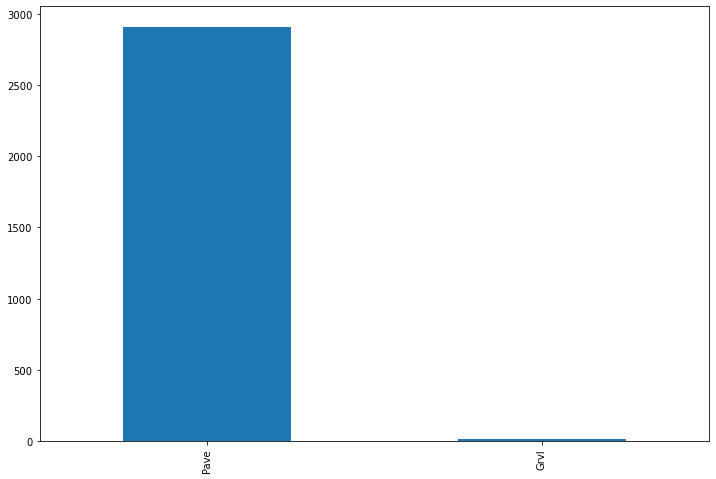

In [69]:
object_columns['Street'].value_counts().plot(kind='bar',figsize=[12,8])
object_columns['Street'].value_counts() 

GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64

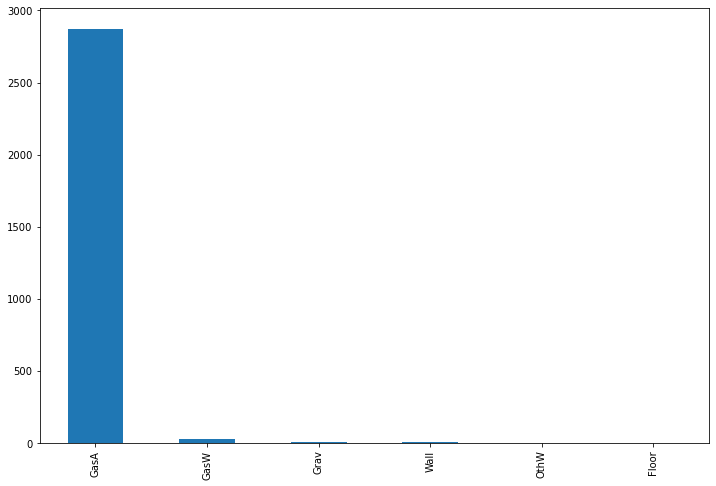

In [70]:
object_columns['Heating'].value_counts().plot(kind='bar',figsize=[12,8])
object_columns['Heating'].value_counts()

CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Roll          1
Metal         1
ClyTile       1
Membran       1
Name: RoofMatl, dtype: int64

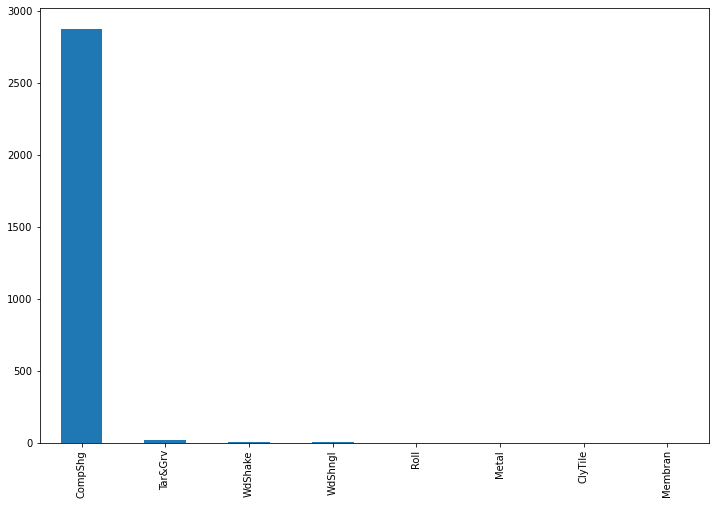

In [71]:
object_columns['RoofMatl'].value_counts().plot(kind='bar',figsize=[12,8])
object_columns['RoofMatl'].value_counts() 

AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64

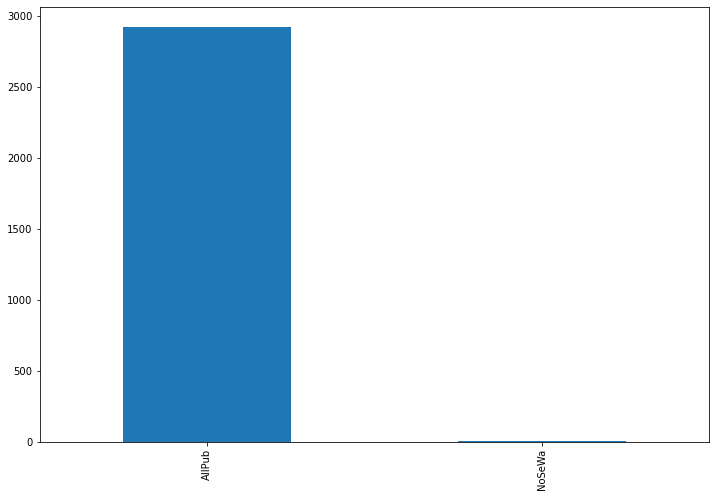

In [72]:
object_columns['Utilities'].value_counts().plot(kind='bar',figsize=[12,8])
object_columns['Utilities'].value_counts() 

Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAe         1
RRAn         1
Name: Condition2, dtype: int64

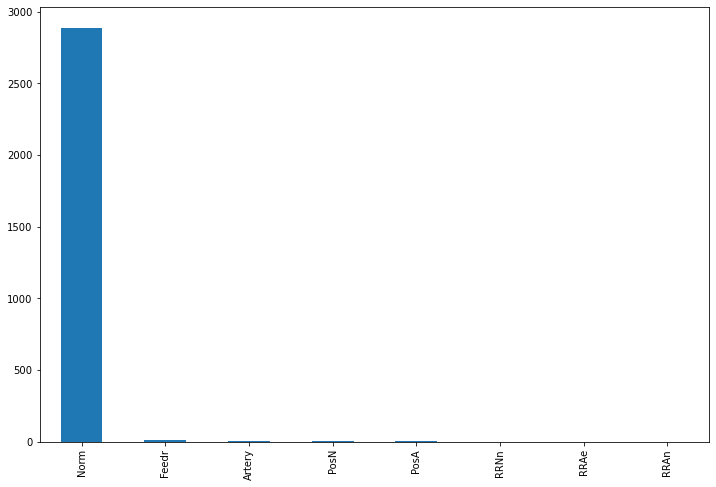

In [73]:
object_columns['Condition2'].value_counts().plot(kind='bar',figsize=[12,8])
object_columns['Condition2'].value_counts()

In [74]:
object_columns = object_columns.drop(['Heating','RoofMatl','Condition2','Street','Utilities'],axis=1)

# Create some new features

In [75]:
numerical_columns['Age_of_House']= (numerical_columns['YrSold']-numerical_columns['YearBuilt'])
numerical_columns['Age_of_House'].describe()

count    2919.000000
mean       36.479959
std        30.336182
min        -1.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: Age_of_House, dtype: float64

We can see there is a minimum value of -1 so lets' see that particular row

In [76]:
negative_age_of_house=numerical_columns[numerical_columns['Age_of_House'] < 0]
negative_age_of_house

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_of_House
1089,2550,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,...,0,0,0,0,17000,10,2007,0.0,0,-1


We can see that the year when the house was built is 2008 and year sold is 2007 which is wrong so we will change the year 2007 to 2010 which will be meaningful.

In [77]:
numerical_columns.loc[numerical_columns['YrSold'] < numerical_columns['YearBuilt'],'YrSold' ] = 2010

In [78]:
numerical_columns['Age_of_House']= (numerical_columns['YrSold']-numerical_columns['YearBuilt'])
numerical_columns['Age_of_House'].describe()

count    2919.000000
mean       36.480987
std        30.334963
min         0.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: Age_of_House, dtype: float64

In [79]:
numerical_columns['TotalBsmtBath'] = numerical_columns['BsmtFullBath'] + numerical_columns['BsmtFullBath']*0.5
numerical_columns['TotalBath'] = numerical_columns['FullBath'] + numerical_columns['HalfBath']*0.5 
numerical_columns['TotalSA']=numerical_columns['TotalBsmtSF'] + numerical_columns['1stFlrSF'] + numerical_columns['2ndFlrSF']

In [80]:
numerical_columns.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_of_House,TotalBsmtBath,TotalBath,TotalSA
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,2,2008,208500.0,1,5,1.5,2.5,2566.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,5,2007,181500.0,1,31,0.0,2.0,2524.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,9,2008,223500.0,1,7,1.5,2.5,2706.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,2,2006,140000.0,1,91,1.5,1.0,2473.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,12,2008,250000.0,1,8,1.5,2.5,3343.0


So our numerical columns are set now its' time to encode the categorical features

In [81]:
object_columns.head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Reg,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,...,Gd,Typ,None,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Fam,1Story,Gable,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,IR1,Lvl,Inside,Gtl,CollgCr,Norm,1Fam,2Story,Gable,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,IR1,Lvl,Corner,Gtl,Crawfor,Norm,1Fam,2Story,Gable,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,IR1,Lvl,FR2,Gtl,NoRidge,Norm,1Fam,2Story,Gable,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


Ordinal categories features - Mapping from 0 to N  

In [82]:
mapping  = {'TA':1,'Gd':3, 'Fa':2,'Ex':5,'Po':7,'None':0,'Y':1,'N':1,'Reg':3,'IR1':2,
            'IR2':1,'IR3':0,"None" : 0,"No" : 5, "Mn" : 4, "Av": 3,
            "Gd" : 4,"Unf" : 1, "LwQ": 2, "Rec" : 3,"BLQ" : 2, "ALQ" : 3, "GLQ" : 6 }
Paveddrive_mapping =   {"N" : 1, "P" : 2, "Y" : 3}
object_columns['ExterQual'] = object_columns['ExterQual'].map(mapping)
object_columns['ExterCond'] = object_columns['ExterCond'].map(mapping)
object_columns['BsmtCond'] = object_columns['BsmtCond'].map(mapping)
object_columns['BsmtQual'] = object_columns['BsmtQual'].map(mapping)
object_columns['HeatingQC'] = object_columns['HeatingQC'].map(mapping)
object_columns['KitchenQual'] = object_columns['KitchenQual'].map(mapping)
object_columns['FireplaceQu'] = object_columns['FireplaceQu'].map(mapping)
object_columns['GarageQual'] = object_columns['GarageQual'].map(mapping)
object_columns['GarageCond'] = object_columns['GarageCond'].map(mapping)
object_columns['CentralAir'] = object_columns['CentralAir'].map(mapping)
object_columns['LotShape'] = object_columns['LotShape'].map(mapping)
object_columns['BsmtExposure'] = object_columns['BsmtExposure'].map(mapping)
object_columns['BsmtFinType1'] = object_columns['BsmtFinType1'].map(mapping)
object_columns['BsmtFinType2'] = object_columns['BsmtFinType2'].map(mapping)
object_columns['PavedDrive'] = object_columns['PavedDrive'].map(Paveddrive_mapping)

One hot encoding will be done to encode the rest of categorical features

In [83]:
remaining_columns = object_columns.select_dtypes(include=['object'])

object_columns = pd.get_dummies(object_columns, columns=remaining_columns.columns) 

Categorical features are now encoded and we will concat categorical and numerical features and make final clean prepared dataset.

In [84]:
data = pd.concat([object_columns, numerical_columns], axis=1,sort=False)
data.head()

,LotShape,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,...,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_of_House,TotalBsmtBath,TotalBath,TotalSA
0,3,4,1,4,1,5,6,1,5,1,...,0,0,2,2008,208500.0,1,5,1.5,2.5,2566.0
1,3,1,1,4,1,4,3,1,5,1,...,0,0,5,2007,181500.0,1,31,0.0,2.0,2524.0
2,2,4,1,4,1,4,6,1,5,1,...,0,0,9,2008,223500.0,1,7,1.5,2.5,2706.0
3,2,1,1,1,4,5,3,1,4,1,...,0,0,2,2006,140000.0,1,91,1.5,1.0,2473.0
4,2,4,1,4,1,3,6,1,5,1,...,0,0,12,2008,250000.0,1,8,1.5,2.5,3343.0


In [85]:
data = data.drop(['Id',],axis=1)
train_data = data[data['train'] == 1]
train_data = train_data.drop(['train',],axis=1)

test_data = data[data['train'] == 0]
test_data = test_data.drop(['SalePrice'],axis=1)
test_data = test_data.drop(['train',],axis=1)

In [86]:
y= train_data['SalePrice']
x = train_data.drop(['SalePrice'],axis=1)

# Different Models

In [87]:
#TRAIN AND TEST SPLITTING
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=0)

In [88]:
xgb =XGBRegressor( booster='gbtree', colsample_bylevel=1,colsample_bynode=1, colsample_bytree=0.6, gamma=0,importance_type='gain',
                  learning_rate=0.02, max_delta_step=0,max_depth=4, min_child_weight=1.5, n_estimators=2000,n_jobs=1, nthread=None,
                  objective='reg:linear',reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, silent=None,subsample=0.8, verbosity=1)


lgbm = LGBMRegressor(objective='regression',num_leaves=4,learning_rate=0.01, n_estimators=12000, max_bin=200, bagging_fraction=0.75,
                                       bagging_freq=5, bagging_seed=7,feature_fraction=0.4)  

In [89]:
xgb.fit(x_train, y_train)
lgbm.fit(x_train, y_train,eval_metric='rmse')

[15:09:18] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:09:30] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.4, learning_rate=0.01, max_bin=200,
              n_estimators=12000, num_leaves=4, objective='regression')

In [90]:
predict_xgb = xgb.predict(x_test)
predict_lgbm = lgbm.predict(x_test)

In [92]:
import sklearn.metrics as metrics
print('RMSE test XGB = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict_xgb))))
print('RMSE test LGBM = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict_lgbm))))

RMSE test XGB = 25850.11296147888
RMSE test LGBM = 27087.971351874832


In [93]:
#Model fitting on whole dataset
xgb.fit(x, y)
lgbm.fit(x,y,eval_metric='rmse')

[15:10:34] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:51] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.4, learning_rate=0.01, max_bin=200,
              n_estimators=12000, num_leaves=4, objective='regression')

In [94]:
new_predict_xgb = xgb.predict(test_data)
new_predict_lgbm = lgbm.predict(test_data)
predict = ( new_predict_xgb*0.45 + new_predict_lgbm * 0.55)

In [95]:
submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": predict})
submission.to_csv('submission.csv', index=False)